Imports
===========

In [1]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import confusion_matrix
import findspark
findspark.init('C:\spark-3.2.1-bin-hadoop3.2')
findspark.find()
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession 
spark = SparkSession.builder\
    .appName("Word Counts")\
    .getOrCreate()
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

TASK1
==============

In [2]:
sc=spark.sparkContext
text=sc.textFile("text.txt")
text=text.flatMap(lambda x:x.split(" "))\
.map(lambda x: (x,1))\
.reduceByKey(lambda x,y: x+y)
text.collect()

[('BBM469', 1),
 ('Intensive', 1),
 ('Applications', 1),
 ('Laboratory', 1),
 ('Assignment', 3),
 ('Machine', 1),
 ('Spark', 9),
 ('Date', 2),
 ('04/04/2022', 1),
 ('Due', 1),
 ('Instructor', 1),
 ('Erdogan', 1),
 ('of', 11),
 ('The', 4),
 ('this', 4),
 ('is', 4),
 ('make', 1),
 ('basics', 1),
 ('Apache', 4),
 ('machine', 2),
 ('learning', 1),
 ('using', 2),
 ('general-purpose', 1),
 ('It', 2),
 ('provides', 1),
 ('high-level', 1),
 ('APIs', 1),
 ('in', 4),
 ('Java,', 1),
 ('Scala,', 1),
 ('R', 1),
 ('programming', 1),
 ('languages,', 1),
 ('an', 1),
 ('optimized', 1),
 ('engine', 1),
 ('supports', 2),
 ('execution', 1),
 ('set', 1),
 ('tools', 1),
 ('SQL', 2),
 ('processing,', 2),
 ('MLlib', 1),
 ('learning,', 1),
 ('GraphX', 1),
 ('graph', 1),
 ('(https://spark.apache.org/docs/latest/).', 1),
 ('provide', 2),
 ('basic', 1),
 ('tutorials', 1),
 ('installation', 1),
 ('usage', 1),
 ('may', 2),
 ('use', 3),
 ('environments', 1),
 ('install', 2),
 ('c45677de0', 1),
 ('Useful', 1),
 ('e-l

TASK2
===


Creation of dataFrames with float values and adding ClassInt column
=====

Since data doesn't have any NA values we didn't handle that. We created "ClassInt" column which is transformation of "Class" column to integer values.Shuffled the dataFrame and created OD and ND below.

In [3]:
df=spark.read.csv("Data.csv",inferSchema=True , header=True)
df.toPandas().isna().sum()
df=df.toPandas()
df['ClassInt']=pd.factorize(df.Class)[0]
df=df.sample(frac=1)
df=spark.createDataFrame(df)
OD=df
ND=(df.toPandas().iloc[:,:-2].astype("float64")-df.toPandas().iloc[:,:-2].astype("float64").min())/(df.toPandas().iloc[:,:-2].astype("float64").max()-df.toPandas().iloc[:,:-2].astype("float64").min())
ND['Class']=OD.toPandas().iloc[:,-2]
ND['ClassInt']=OD.toPandas().iloc[:,-1].astype("float64")
ND=spark.createDataFrame(ND)

We can see which Class converted into which integer below.

In [4]:
OD.groupBy("Class").count().show()
OD.groupBy("ClassInt").count().show()

+--------+-----+
|   Class|count|
+--------+-----+
|    CALI| 1630|
|   SEKER| 2027|
|    SIRA| 2636|
|   HOROZ| 1928|
|  BOMBAY|  522|
|BARBUNYA| 1322|
|DERMASON| 3546|
+--------+-----+

+--------+-----+
|ClassInt|count|
+--------+-----+
|       0| 2027|
|       6| 3546|
|       5| 2636|
|       1| 1322|
|       3| 1630|
|       2|  522|
|       4| 1928|
+--------+-----+



Adding "features" column to work with Clustering and Classification models

In [5]:
input_cols=['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']
vec_assembler=VectorAssembler(inputCols=input_cols,outputCol="features")
OD=vec_assembler.transform(OD)
ND=vec_assembler.transform(ND)

Implementation of Kmeans clustering
===

In [6]:
kmeans = KMeans(featuresCol="features", k=7)
model=kmeans.fit(OD)
predictions_od=model.transform(OD)
model=kmeans.fit(ND)
predictions_nd=model.transform(ND)

In [8]:
print("Rand score of the normalized data = {}".format(rand_score(predictions_nd.select("prediction").toPandas().iloc[:,0],predictions_nd.select("Class").toPandas().iloc[:,0])))
print("Rand score of the organized data = {}".format(rand_score(predictions_od.select("prediction").toPandas().iloc[:,0],predictions_od.select("Class").toPandas().iloc[:,0])))


Rand score of the normalized data = 0.8893623717385952
Rand score of the organized data = 0.8056870088921357


Graphs of clustering.
===============

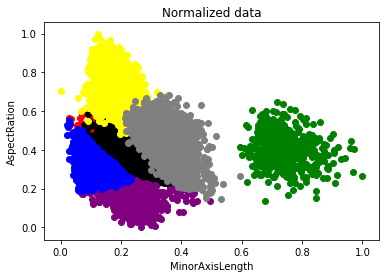

None


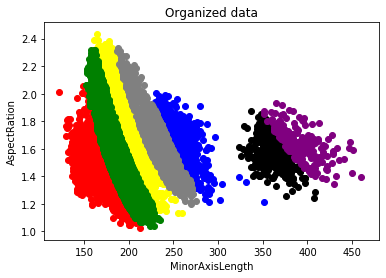

None


In [9]:
normalized_organized=predictions_nd.toPandas()
filtered_label0=normalized_organized[normalized_organized['prediction']==0]
filtered_label1=normalized_organized[normalized_organized['prediction']==1]
filtered_label2=normalized_organized[normalized_organized['prediction']==2]
filtered_label3=normalized_organized[normalized_organized['prediction']==3]
filtered_label4=normalized_organized[normalized_organized['prediction']==4]
filtered_label5=normalized_organized[normalized_organized['prediction']==5]
filtered_label6=normalized_organized[normalized_organized['prediction']==6]
filtered_label7=normalized_organized[normalized_organized['prediction']==7]
plt.scatter(filtered_label0.iloc[:,3] , filtered_label0.iloc[:,4] , color = 'red')
plt.scatter(filtered_label1.iloc[:,3] , filtered_label1.iloc[:,4] , color = 'black')
plt.scatter(filtered_label2.iloc[:,3] , filtered_label2.iloc[:,4] , color = 'yellow')
plt.scatter(filtered_label3.iloc[:,3] , filtered_label3.iloc[:,4] , color = 'green')
plt.scatter(filtered_label4.iloc[:,3] , filtered_label4.iloc[:,4] , color = 'purple')
plt.scatter(filtered_label5.iloc[:,3] , filtered_label5.iloc[:,4] , color = 'blue')
plt.scatter(filtered_label6.iloc[:,3] , filtered_label6.iloc[:,4] , color = 'gray')
plt.xlabel("MinorAxisLength")
plt.ylabel("AspectRation")
plt.title("Normalized data")
print(plt.show())
normalized_organized=predictions_od.toPandas()
filtered_label0=normalized_organized[normalized_organized['prediction']==0]
filtered_label1=normalized_organized[normalized_organized['prediction']==1]
filtered_label2=normalized_organized[normalized_organized['prediction']==2]
filtered_label3=normalized_organized[normalized_organized['prediction']==3]
filtered_label4=normalized_organized[normalized_organized['prediction']==4]
filtered_label5=normalized_organized[normalized_organized['prediction']==5]
filtered_label6=normalized_organized[normalized_organized['prediction']==6]
filtered_label7=normalized_organized[normalized_organized['prediction']==7]
plt.scatter(filtered_label0.iloc[:,3] , filtered_label0.iloc[:,4] , color = 'red')
plt.scatter(filtered_label1.iloc[:,3] , filtered_label1.iloc[:,4] , color = 'black')
plt.scatter(filtered_label2.iloc[:,3] , filtered_label2.iloc[:,4] , color = 'yellow')
plt.scatter(filtered_label3.iloc[:,3] , filtered_label3.iloc[:,4] , color = 'green')
plt.scatter(filtered_label4.iloc[:,3] , filtered_label4.iloc[:,4] , color = 'purple')
plt.scatter(filtered_label5.iloc[:,3] , filtered_label5.iloc[:,4] , color = 'blue')
plt.scatter(filtered_label6.iloc[:,3] , filtered_label6.iloc[:,4] , color = 'gray')
plt.xlabel("MinorAxisLength")
plt.ylabel("AspectRation")
plt.title("Organized data")
print(plt.show())

Prepared datasets for Classification

In [10]:
CND=ND.select("features","ClassInt")
COD=OD.select("features","ClassInt")

In [ ]:
Created our classifier below. We chose RandomForestClassifier

In [11]:
classifier=RandomForestClassifier(labelCol="ClassInt")

In this function we implement classification with k-fold cross validation. Function prints the result metrics. 

In [12]:
def kfold(k,data,classifier,whichData):
    crossval= CrossValidator(estimator=classifier,estimatorParamMaps= ParamGridBuilder().addGrid(classifier.maxDepth, [ 10]).build(), evaluator=MulticlassClassificationEvaluator(labelCol="ClassInt"),numFolds=k)
    cvModel=crossval.fit(data)
    prediction = cvModel.transform(data)
    accuracy=MulticlassClassificationEvaluator(labelCol="ClassInt",metricName="accuracy").evaluate(prediction)
    f1=MulticlassClassificationEvaluator(labelCol="ClassInt",metricName="f1").evaluate(prediction)
    weightedRecall=MulticlassClassificationEvaluator(labelCol="ClassInt",metricName="weightedRecall").evaluate(prediction)
    weightedPrecision=MulticlassClassificationEvaluator(labelCol="ClassInt",metricName="weightedPrecision").evaluate(prediction)
    print("F1 of the {} data with {} folds = {} ".format( whichData, k, f1))
    print("Weighted Recall of the {} data with {} folds = {} ".format( whichData, k, weightedRecall))
    print("Weighted Precision of the {} data with {} folds = {} ".format( whichData, k, weightedPrecision))
    print("Accuracy of the {} data with {} folds = {} ".format( whichData, k, accuracy))
    print("Confusion Matrix of the {} data with {} folds = \n{}".format(whichData, k, confusion_matrix(prediction.toPandas().iloc[:,1],prediction.toPandas().iloc[:,4])))

In [13]:
kfold(3,COD,classifier,"organized")

F1 of the organized data with 3 folds = 0.9467628539909032 
Weighted Recall of the organized data with 3 folds = 0.9466607890676659 
Weighted Precision of the organized data with 3 folds = 0.947145482219875 
Accuracy of the organized data with 3 folds = 0.9466607890676658 
Confusion Matrix of the organized data with 3 folds = 
[[1952    4    0    1    0   47   23]
 [   5 1198    0   87    3   29    0]
 [   0    0  519    3    0    0    0]
 [   1   43    0 1555   18   13    0]
 [   0    7    0   20 1849   42   10]
 [  12    1    0    4   19 2421  179]
 [  19    0    0    0    1  135 3391]]


In [14]:
kfold(3,CND,classifier,"normalized")

F1 of the normalized data with 3 folds = 0.9467628539909032 
Weighted Recall of the normalized data with 3 folds = 0.9466607890676659 
Weighted Precision of the normalized data with 3 folds = 0.947145482219875 
Accuracy of the normalized data with 3 folds = 0.9466607890676658 
Confusion Matrix of the normalized data with 3 folds = 
[[1952    4    0    1    0   47   23]
 [   5 1198    0   87    3   29    0]
 [   0    0  519    3    0    0    0]
 [   1   43    0 1555   18   13    0]
 [   0    7    0   20 1849   42   10]
 [  12    1    0    4   19 2421  179]
 [  19    0    0    0    1  135 3391]]
